<a href="https://colab.research.google.com/github/ecuadrafoy/PracticalMachineLearning/blob/master/DeployingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deploy Keras Model to the Cloud
1. Download data
2. Hot Encode Categorical Columns
3. Develop Model (use: ```RMSprop(lr=, rho=, epsilon=, decay=)```)
3. Create Storage Bucket (should already exist)
4. Authenticate on Google Cloud Platform
5. Deploy your model using the ```gcloud``` tool

In [ ]:
!wget https://storage.googleapis.com/nicksdemobucket/bank.csv

--2020-08-02 19:38:34--  https://storage.googleapis.com/nicksdemobucket/bank.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4610348 (4.4M) [application/octet-stream]
Saving to: ‘bank.csv’

bank.csv            100%[===================>]   4.40M  --.-KB/s    in 0.04s   

2020-08-02 19:38:35 (107 MB/s) - ‘bank.csv’ saved [4610348/4610348]



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('bank.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
df.loc[df['y'] == 'no', 'y'] = 0
df.loc[df['y'] == 'yes', 'y'] = 1
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [ ]:
# Get all categorical columns
categorical = df.select_dtypes(include='object').columns
print(categorical)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')


In [ ]:
# Hot encode all categorical columns

df2 = pd.get_dummies(df,columns=categorical, drop_first=True)
df2

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_1
0,58,2143,5,261,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,44,29,5,151,1,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,33,2,5,76,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,47,1506,5,92,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,33,1,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
45207,71,1729,17,456,2,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
45208,72,5715,17,1127,5,184,3,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
45209,57,668,17,508,4,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
# TODO - Process Data
X = df2.drop(['y_1'], axis=1).values
Y = df2[['y_1']].values

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1)

X_train.shape, y_train.shape



((40689, 42), (40689, 1))

In [ ]:
X.shape[1]

42

In [ ]:
# TODO - Develop Model 

model = Sequential()

model.add(Dense(40, input_shape=(X_train.shape[1], ), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer = RMSprop(learning_rate=0.01, rho=0.7, epsilon=1e-08),
              metrics=['accuracy'])



In [ ]:
h = model.fit(X_train, y_train, epochs = 100, validation_split=0.2, verbose=0)

142/142 - 0s - loss: 0.0000e+00 - accuracy: 0.1179

Test accuracy: 0.11786819994449615


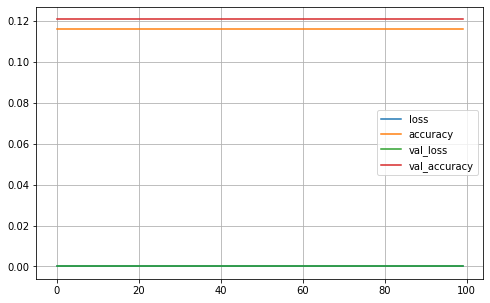

In [ ]:
#Evaluating accuracy
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose = 2)
print('\nTest accuracy:', test_acc)

pd.DataFrame(h.history).plot(figsize=(8,5), ls='-')
plt.grid(True)
plt.gca()
plt.show()

In [ ]:
# TODO -  Set project name, bucket name, authenticate to GCP
PROJECT_ID = 'blueprint-258003'
BUCKET_NAME = 'classbucket2020'
REGION = 'us-east1'

JOB_DIR = 'gs://' + BUCKET_NAME + '/homework8'



In [ ]:
import sys

from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
export_path = tf.keras.models.save_model(model, JOB_DIR + '/keras_export')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: gs://classbucket2020/homework8/keras_export/assets


In [ ]:
MODEL_NAME = "modelbank"

! gcloud ai-platform models create $MODEL_NAME --regions $REGION

MODEL_VERSION = 'v1'
SAVED_MODEL_PATH = 'gs://classbucket2020/homework8/keras_export'

Using endpoint [https://ml.googleapis.com/]
Created ml engine model [projects/blueprint-258003/models/modelbank].


In [ ]:
! gcloud ai-platform versions create $MODEL_VERSION \
--model $MODEL_NAME \
--runtime-version 1.13 \
--python-version 3.5 \
--framework tensorflow \
--origin $SAVED_MODEL_PATH

Using endpoint [https://ml.googleapis.com/]


In [ ]:
test_set = list(X[10])

[41,
 270,
 5,
 222,
 1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1]

In [ ]:
%%bash
rm prediction_input.json
touch prediction_input.json
echo "[41, 270, 5, 222, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]" >> prediction_input.json
cat prediction_input.json

[41, 270, 5, 222, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]


In [ ]:
# TODO -  Test Model
! gcloud ai-platform predict \
  --model $MODEL_NAME \
  --version $MODEL_VERSION \
  --json-instances prediction_input.json

Using endpoint [https://ml.googleapis.com/]
DENSE_7
[1.0]
